## Project 5.1. Neural network classification - stroke prediction
Key things:
* Imbalanced dataset - with classical techniques, we were only able to achieve high recall (true positive count) with a tradeoff of high false positive rate - but, it fit our "business value"
* Can neural networks achieve high recall on minority class, without sacrificing precision? Can we get a better precision-recall curve?
* Tensorflow first
* Tested on raw, cleaned data and with engineered features
* Will class weighting be necessary? How possible is it? Tuning the output prediction threshold necessary?
* Hyperparameter search?
* Output and intermediary activation functions etc explorations

### Code setup

In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# classification
from sklearn.svm import SVC
from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay, 
                            roc_curve, precision_recall_curve,
                            auc, make_scorer, recall_score, accuracy_score, precision_score
                            )

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.random.set_seed(111)

#### Datasets
* df - raw dataset
* df_eng - bmi values imputed, 'yes'/'no' changed to 0/1
* df_enc - categorical values one-hot and ordinally (smoking) encoded

In [7]:
df_path = '../datasets/stroke_data.csv'
df_eng_path = '../datasets/stroke_data_eng.csv'
df_enc_path = '../datasets/stroke_data_enc.csv'
df = pd.read_csv(df_path, index_col=0)
df_eng = pd.read_csv(df_eng_path, index_col=0)
df_enc = pd.read_csv(df_enc_path, index_col=0)

In [8]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [9]:
df_eng.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1
31112,Male,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1


In [10]:
df_enc.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
id,,,,,,,,,,,,,,,,,,
9046,67.0,0,1,1,228.69,36.600000,1,1,False,True,False,False,False,True,False,False,False,True
51676,61.0,0,0,1,202.21,28.893237,0,1,True,False,False,False,False,False,True,False,True,False
31112,80.0,0,1,1,105.92,32.500000,0,1,False,True,False,False,False,True,False,False,True,False
60182,49.0,0,0,1,171.23,34.400000,2,1,True,False,False,False,False,True,False,False,False,True
1665,79.0,1,0,1,174.12,24.000000,0,1,True,False,False,False,False,False,True,False,True,False


In [11]:
df_enc.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
Female                  bool
Male                    bool
Other                   bool
Govt_job                bool
Never_worked            bool
Private                 bool
Self-employed           bool
children                bool
Rural                   bool
Urban                   bool
dtype: object

### EDA
Even though we looked at the data more in-depth in Project 3, let's refresh at least the data distributions

In [12]:
cols = df.columns

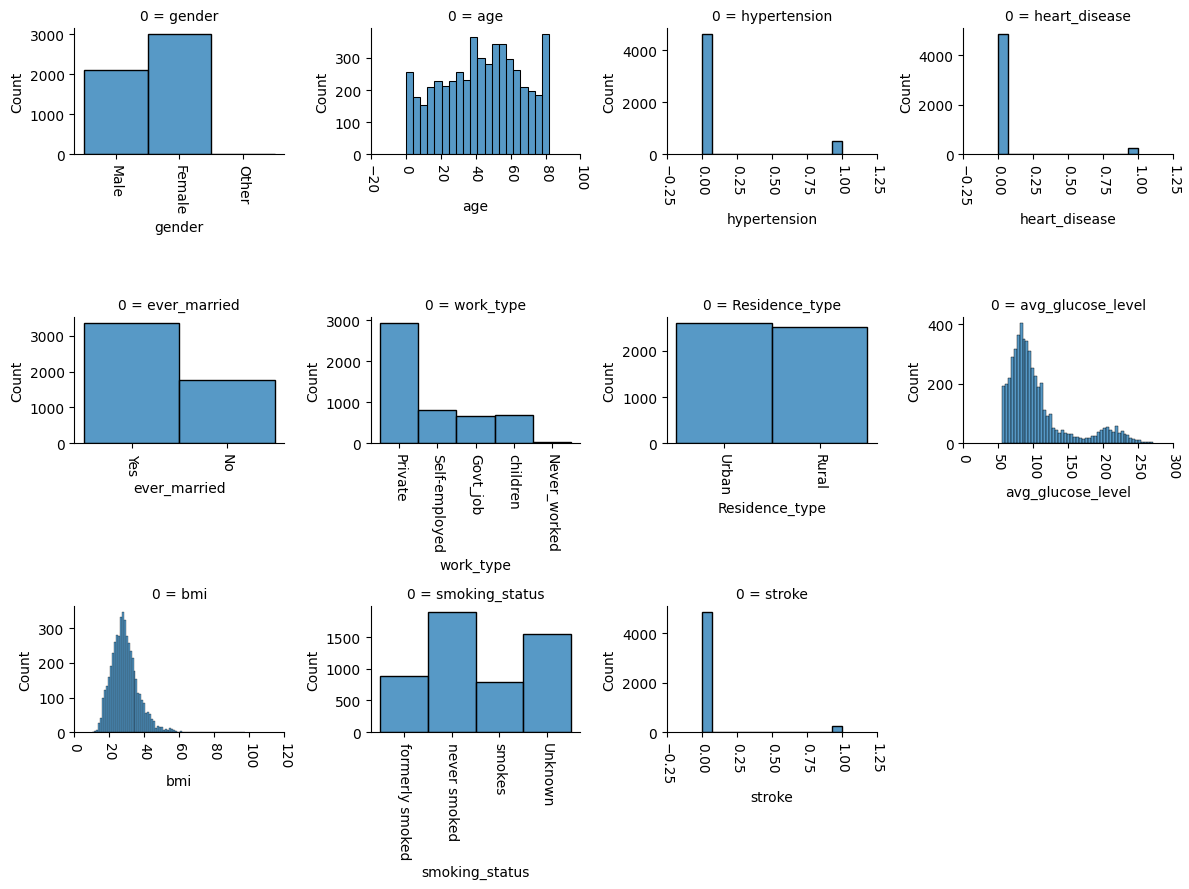

In [13]:
g = sns.FacetGrid(pd.DataFrame(list(cols)), col=0, col_wrap=4, sharex=False, sharey=False)
for ax, col in zip(g.axes, list(cols)):
    sns.histplot(df[col], ax=ax)
g.set_xticklabels(rotation=-90)
g.tight_layout()

A lot of these variables have quite skewed, imbalanced distributions, which is very important to keep in mind

#### Stroke vs no stroke

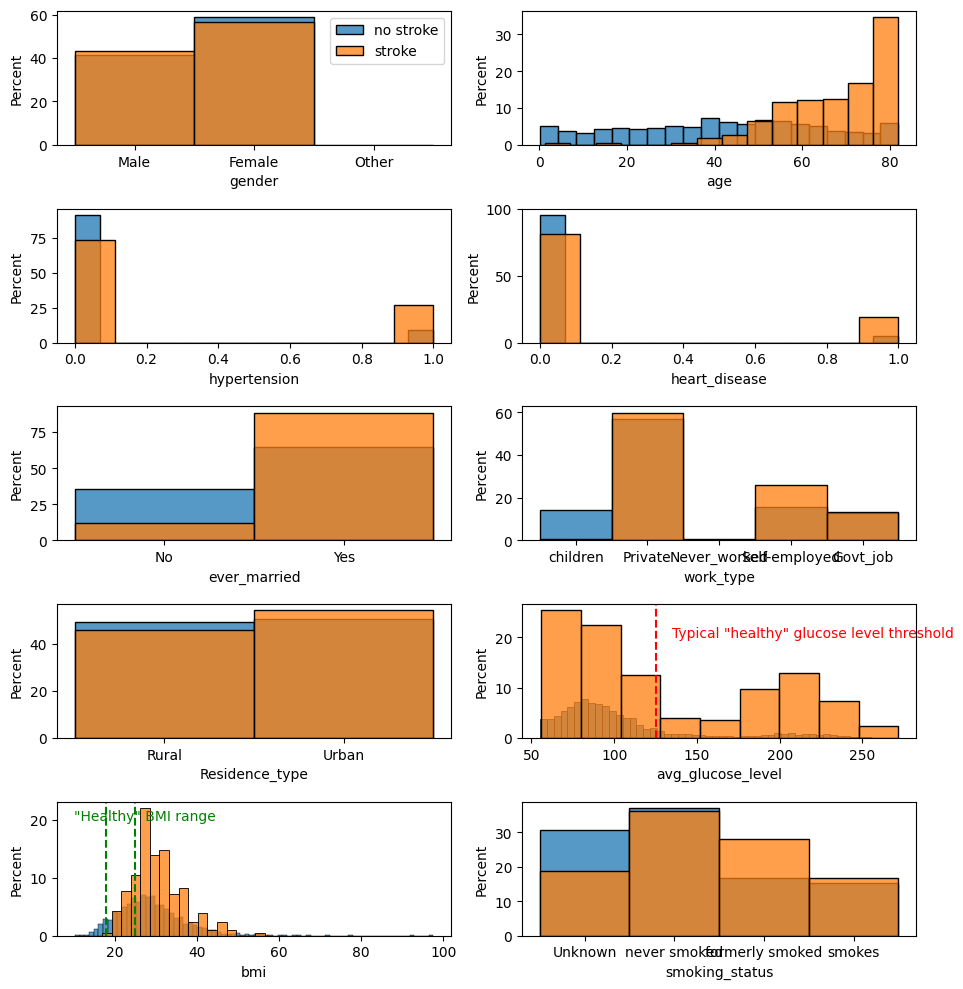

In [14]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
stroke_df = df[df['stroke'] == 1]
nostroke_df = df[df['stroke'] == 0]
cols_no_stroke = [col for col in cols if col != 'stroke']

ax = axes.ravel()

for i in range(10):
    # sns.histplot(data=df, x=cols_no_stroke[i], hue='stroke', stat='density', ax=ax[i])
    sns.histplot(data = nostroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])
    sns.histplot(data = stroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])

    # additional vertical lines
    dist_col = cols_no_stroke[i]
    if dist_col == 'bmi':
        ax[i].axvline(x=18, ymin=0, ymax=30, color="green", linestyle="dashed")
        ax[i].axvline(x=25, ymin=0, ymax=30, color="green", linestyle="dashed")
        ax[i].text(10, 20, '"Healthy" BMI range', color="green")
    if dist_col == "avg_glucose_level":
        ax[i].axvline(x=125, ymin=0, ymax=30, color="red", linestyle="dashed")
        ax[i].text(135, 20, 'Typical "healthy" glucose level threshold', color="red")
ax[0].legend(['no stroke', 'stroke'], loc='best')
fig.tight_layout()

### Neural nets
Initially, let's work on the cleaned and encoded dataset (all numerical columns), with scaling to 0-1 applied, as the spread of value ranges within the dataset is quite large, next, if necessary an exploration with engineered features such as binning bmi or average glucose levels and encoding these bin categories

#### X-y split

In [15]:
X = df_enc.drop(['stroke'], axis=1)
y = pd.DataFrame(df_enc['stroke'])

Important! As this is a **significantly imbalanced** dataset (only about 5% of cases are of label '1'), whilst splitting the data, you need to stratify on the target labels, which, in scikit-learn will ensure the data is split to keep the proportion of classes within the sets intact **(done in test_nn_model function)**

In [16]:
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

### Function to compile and test classification NN models
* accepts model, X and y
* to scale or not to scale
* to early stop, lr_schedule, loss choice etc

In [17]:
# data_dict = {
#     'X_train': X_train,
#     'y_train': y_train,
#     'X_test': X_test,
#     'y_test': y_test
# }

In [158]:
def test_nn_model_classif(model, X, y,
                  test_split = 0,
                  scale = True,
                  class_weight = None,
                  optimizer=tf.keras.optimizers.Adam,
                  metrics = None,
                  loss=tf.keras.losses.BinaryCrossentropy, lr=0.001, batch_size=256, epochs=50,
                  verbose = False,
                  early_stop=True,
                  monitor = 'val_accuracy',
                  monitor_mode = 'auto',
                  lr_schedule=False):
    """
    Trains a NN model that you supply (uncompiled), along with data X, y, whether to scale and other training params
    ---
    Params:
        model
        X - dataframe of factors
        y - target dataframe / series
        test_split: int (default: 0) - the size of the test split, if necessary, will be split if test_split > 0
        scale: bool (default: True) - to MinMaxScale (to 0-1) or not
        class_weight (default None) - if supplied, will assign different weight to classes
            during fitting, expected in the form of a dict of form {class : class_weight (number)}
        optimizer: tf.keras.optimizer function object (default: tf.keras.optimizers.Adam)
        metrics: list (eg. ['accuracy'])
        loss: tf.keras.losses function object (default: tf.keras.losses.BinaryCrossentropy)
        batch_size: int (default: 256)
        epochs: int (default 50)
        verbose: bool (default: False)
        early_stop: bool (default: True)
        monitor: String (default 'loss') - which metric to monitor for early stopping.
            Could be 'accuraccy', (or 'val_accuracy') 'loss' or 'val_prc' when looking at the precision-recall tradeoff
        monitor_mode: String (default: 'auto') - whether to cut off training when monitor metric stops going down ('min')
            or up ('max') - 'auto' should work, but if you're sure or getting bad results try 'min' or 'max'
        lr_schedule: bool (default: False)
    ---
    Returns:
        history - model training (fit) history object
        X_test - the train data used
        y_test
        scaler_X - the scaler used for input (X) values
        metrics_result : list of metrics
    """

    # train-test-split
    X_cols = list(X.columns)
    y_col = list(y.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify = y, test_size=test_split)

    if scale == True:
        scaler_X = MinMaxScaler()
        scaler_X.fit(X_train[X_cols])

        # this is a classification problem! we'd like to keep the classes as numbers / the output
        # function/activation doesn't care about the numbers, it returns probabilities
        
        # scaler_y = MinMaxScaler()
        # scaler_y.fit(pd.DataFrame(y_train))

        X_train[X_cols] = scaler_X.transform(X_train[X_cols])
        X_test[X_cols] = scaler_X.transform(X_test[X_cols])
        # y_train[y_col] = scaler_y.transform(y_train[y_col])
        # y_test = scaler_y.transform(y_test[y_col])
    
    # prepare the learning rate decay
    # https://stackoverflow.com/questions/61552475/
    # properly-set-up-exponential-decay-of-learning-rate-in-tensorflow
    train_size = X_train.shape[0]
    initial_lr = lr
    final_lr = initial_lr / 100
    lr_decay_factor  = (final_lr / initial_lr) ** (1/epochs)
    steps_per_epoch = int(train_size/batch_size)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr,
                decay_steps=steps_per_epoch,
                decay_rate=lr_decay_factor,
                staircase=True)

    #optimizer
    if lr_schedule == True:
        optim = optimizer(
            learning_rate = lr_schedule
        )
    else:
        optim = optimizer(
            learning_rate = lr
        )

    # model compilation   
    model.compile(
        optimizer = optim,
        loss = loss,
        metrics = metrics
    )
                          
    # prepare early stopping
    # if monitor == 'accuracy':
    
    early_stopping = EarlyStopping(
        # min_delta=0.001, # minimium amount of change to count as an improvement
        patience=10, # how many epochs to wait before stopping
        monitor = monitor,
        mode = monitor_mode,
        restore_best_weights=True,
    )

    # if monitor == 'val_prc'
    # early_stopping = EarlyStopping(
    #     # min_delta=0.001, # minimium amount of change to count as an improvement
    #     # patience=10, # how many epochs to wait before stopping
    #     monitor = 'val_prc',
    #     verbose=1,
    #     patience=10,
    #     mode='max',
    #     restore_best_weights=True,
    # )

    callbacks = []
    if early_stop == True:
        callbacks.append(early_stopping)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = callbacks,
        verbose = verbose,
        class_weight = class_weight
    )

    # convert the training history to a dataframe
    history_df = pd.DataFrame(history.history)
    # use Pandas native plot method
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    sns.lineplot(history_df['loss'], ax=ax)
    sns.lineplot(history_df['val_loss'], ax=ax)
    ax.legend(['training loss', 'validation loss'], loc='best')
    # sns.histplot(data = nostroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])
    # history_df['loss'].plot(ax = ax);
    # history_df['val_loss'].plot(ax = ax);
    ax.set_xlabel('epochs')
    fig.show()

    # predictions, unscaling etc
    y_pred = model.predict(X_test)
    
    # mae = mean_absolute_error(y_test, y_pred)
    # print('mae: ', mae)
    # if scale == True:
    #     mae_inv = mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred))
    #     print('mae on inv scaled:', mae_inv)
    #     return X_test, y_test, mae, mae_inv, scaler_X, scaler_y

    metrics_result = []
    metrics_result = model.evaluate(X_test, y_test)
    print('Accuracy achieved: ', metrics_result)

    # return mae
    return history, X_test, y_test, scaler_X, metrics_result

In [27]:
n_features = X.shape[1]
n_features

17

In [28]:
output_shape = int(y.nunique().iloc[0])
output_shape

2

In [29]:
model_1 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[n_features]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

 1/40 [..............................] - ETA: 0s - loss: 0.0498 - accuracy: 0.9688

C:\Users\User\AppData\Local\Temp\ipykernel_20504\603373532.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1ms/step - loss: 0.1566 - accuracy: 0.9523
Accuracy achieved:  [0.15659692883491516, 0.9522691965103149]


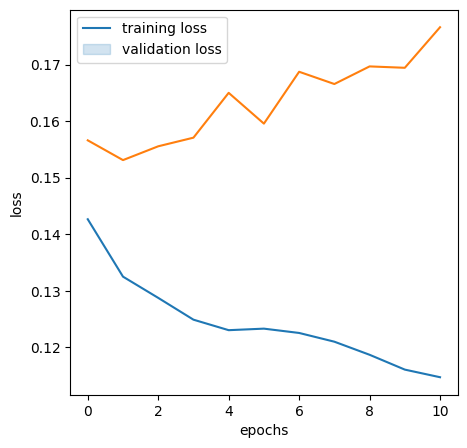

In [51]:
history, X_test, y_test, scaler_X, metrics_result = test_nn_model_classif(model_1, X, y,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = ['accuracy'],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=512, epochs=50,
              early_stop=True,
              monitor = 'val_accuracy',  
              lr_schedule=True)

In [52]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.142645,0.954593,0.156597,0.952269
1,0.132493,0.955376,0.153102,0.948357
2,0.128738,0.957724,0.155543,0.952269
3,0.124885,0.959290,0.157069,0.952269
4,0.123028,0.959290,0.164996,0.940532


In [53]:
model_1.evaluate(X_test, y_test)

40/40 [==============================] - 0s 1ms/step - loss: 0.1566 - accuracy: 0.9523


[0.15659692883491516, 0.9522691965103149]

A 95% accuracy.. nice, right? Well, not quite. It could just mean the model is guessing 0 everytime, as the percentage of class 0 within the dataset is.. 95%. Let's look at the results further

In [54]:
y_pred = model_1.predict(X_test)
y_pred_binary = tf.round(y_pred)

40/40 [==============================] - 0s 964us/step


In [55]:
model_1_report = classification_report(y_test, y_pred_binary)
print(model_1_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.67      0.03      0.06        62

    accuracy                           0.95      1278
   macro avg       0.81      0.52      0.52      1278
weighted avg       0.94      0.95      0.93      1278



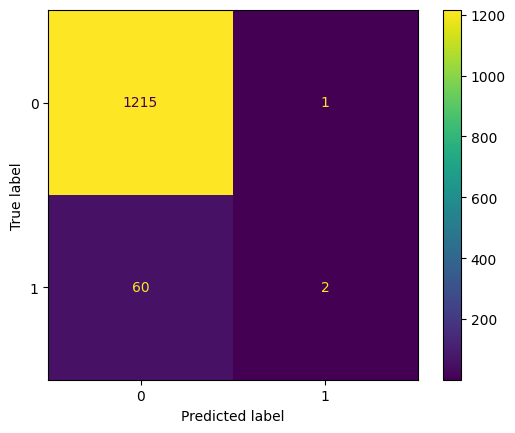

In [56]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
disp.plot()

Indeed - the recall for class 1 is very close to 0. Not at all what we needed

### Class imbalance mitigation

#### Classification threshold

In [57]:
y_pred[:, 0]

array([2.9083552e-02, 3.8766579e-03, 3.2062039e-02, ..., 1.8389960e-09,
       5.6154195e-06, 6.3947443e-04], dtype=float32)

In [67]:
preds_thresh = (y_pred[:,0] >= 0.03).astype('int')
preds_thresh

array([0, 0, 1, ..., 0, 0, 0])

In [68]:
unique, counts = np.unique(preds_thresh, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 946]
 [  1 332]]


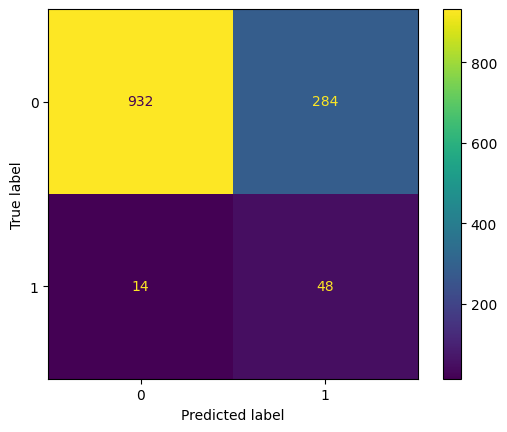

In [69]:
cm = confusion_matrix(y_test, preds_thresh)
disp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
disp.plot()

In [70]:
model_1_report_thresh = classification_report(y_test, preds_thresh)
print(model_1_report_thresh)

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1216
           1       0.14      0.77      0.24        62

    accuracy                           0.77      1278
   macro avg       0.56      0.77      0.55      1278
weighted avg       0.94      0.77      0.83      1278



Okay, with just adjusting the threshold we were able to get slightly (but, nonetheless, existing) better results, with a slightly better recall for class "1" with a noticeable lesser sacrifice to class's "0" precision.

## Proper NN adjustments for imbalance in data
Decision threshold tuning is fine, but maybe there is a better way to make the model perform better internally, instead of tuning the results "externally". Let's look at a few possible approaches, mostly guided by tensorflow's docs on this topic:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data.

Additionally, throghout the experiments we will be looking at more metrics in depth, such as the precision, recall, prc curves etc. With the focus shifted to the recall on class '1', the early stopping and other tuning methods will be focused on that as well, instead of the accuracy.

#### initial bias (for class imbalance) adjustment of the final classification neuron activation function
Let's try guiding (biasing) the output function to look at class 1 more in-depth

Some other important factors to consider:
* different early stopping metric
* increased batch size, to ensure each batch has a higher chance of containing some smaples of class '1'
* (general) Dropout

Calculating the initial bias:

In [100]:
pos = y[y['stroke'] == 1].shape[0]
neg = y[y['stroke'] == 0].shape[0]

In [101]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.97154656])

In [102]:
output_bias = tf.keras.initializers.Constant(initial_bias)

In [123]:
model_2 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[n_features]),
    layers.Dropout(0.25),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
])

40/40 [==============================] - 0s 1000us/step


C:\Users\User\AppData\Local\Temp\ipykernel_20504\4046570174.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1ms/step - loss: 0.1578 - accuracy: 0.9507 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8486 - prc: 0.2101
Accuracy achieved:  [0.1578490138053894, 0.9507042169570923, 0.0, 0.0, 0.848564863204956, 0.2101445198059082]


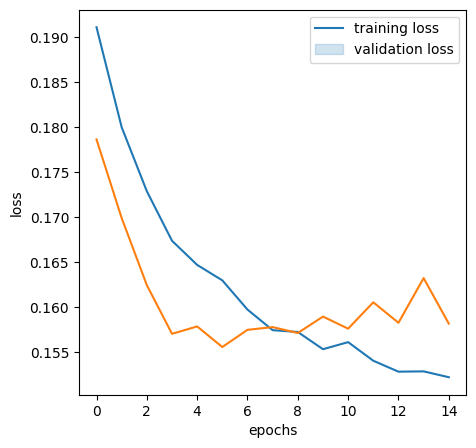

In [124]:
history, X_test, y_test, scaler_X, metrics = test_nn_model_classif(
              model_2, X, y,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = [
                  keras.metrics.BinaryAccuracy(name='accuracy'),
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc'), 
                  keras.metrics.AUC(name='prc', curve='PR') #precision-recall curve
              ],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=1024, epochs=50,
              early_stop=True,
              monitor = 'val_prc',
              monitor_mode = 'max',
              lr_schedule=True)

### Function to report model results (classification report, confusion), with additional thresholding

In [105]:
def report_cm_threshold(model, X_test, y_test, threshold = 0):
    """
    Prints out prediction result statistics, classification report, confusion matrix, additionally with an applied threshold
    if value of threshold > 0
    ---
    Params:
        model
        X_test
        y_test
        theshold (0-1)
    """
    y_pred = model.predict(X_test)
    y_pred_binary = tf.round(y_pred)

    if threshold > 0:
        y_pred_binary = (y_pred[:,0] >= threshold).astype('int')

    print('predictions class count:')
    unique, counts = np.unique(y_pred_binary, return_counts=True)
    print(np.asarray((unique, counts)).T)

    print('model report:')
    model_report = classification_report(y_test, y_pred_binary)
    print(model_report)

    print('confusion matrix:')
    cm = confusion_matrix(y_test, y_pred_binary)
    disp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
    disp.plot()

40/40 [==============================] - 0s 2ms/step
predictions class count:
[[0.000e+00 1.277e+03]
 [1.000e+00 1.000e+00]]
model report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278

confusion matrix:


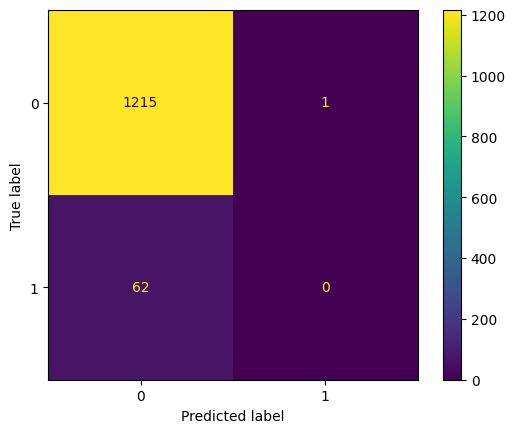

In [125]:
report_cm_threshold(model_2, X_test, y_test) 

No improvement? Let's check it out with threshold tuning

40/40 [==============================] - 0s 996us/step
predictions class count:
[[  0 889]
 [  1 389]]
model report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1216
           1       0.13      0.81      0.22        62

    accuracy                           0.73      1278
   macro avg       0.56      0.76      0.53      1278
weighted avg       0.94      0.73      0.80      1278

confusion matrix:


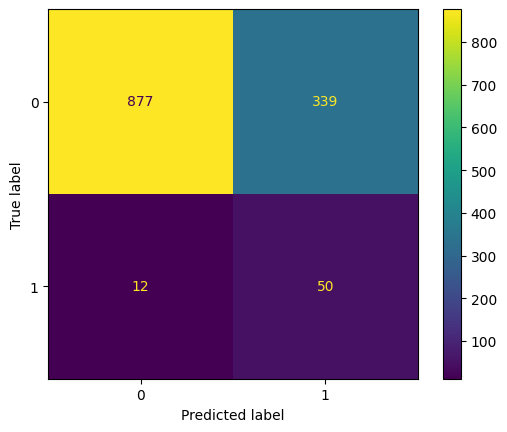

In [130]:
report_cm_threshold(model_2, X_test, y_test, threshold=0.07)

Unfortunately, even with (naive, but still) threshold tuning, we cannot with confidence say the model performed much better

### Function to plot more metrics

In [133]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [140]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout()

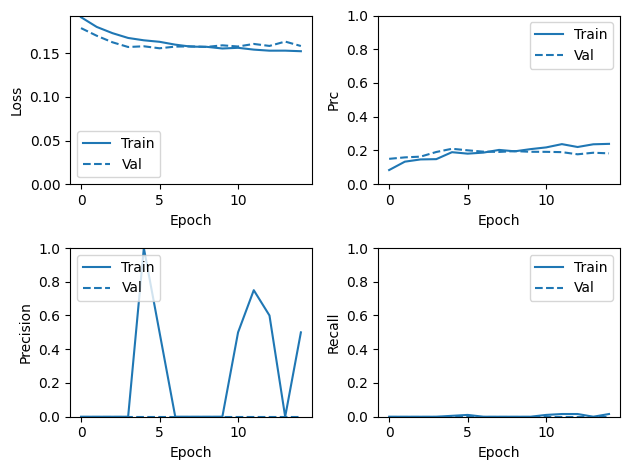

In [141]:
plot_metrics(history)

#### Smaller model? A lot of overfitting and generally weird behaviour

In [149]:
model_3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[n_features]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
])

 1/40 [..............................] - ETA: 0s - loss: 0.1785 - accuracy: 0.9375 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8667 - prc: 0.1831

C:\Users\User\AppData\Local\Temp\ipykernel_20504\4046570174.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1ms/step - loss: 0.1665 - accuracy: 0.9515 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8086 - prc: 0.1597
Accuracy achieved:  [0.16647028923034668, 0.9514867067337036, 0.0, 0.0, 0.808573842048645, 0.15973252058029175]


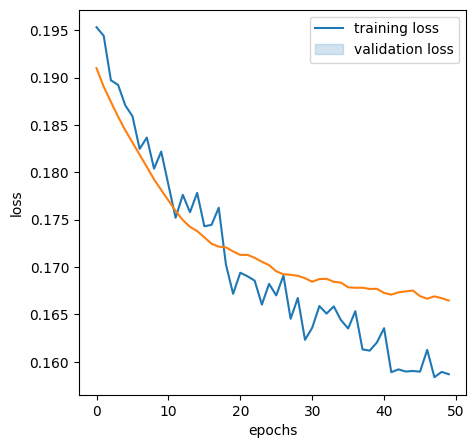

In [150]:
history, X_test, y_test, scaler_X, metrics = test_nn_model_classif(
              model_3, X, y,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = [
                  keras.metrics.BinaryAccuracy(name='accuracy'),
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc'), 
                  keras.metrics.AUC(name='prc', curve='PR') #precision-recall curve
              ],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=1024, epochs=50,
              early_stop=True,
              monitor = 'val_prc',
              monitor_mode = 'max',
              lr_schedule=True)

40/40 [==============================] - 0s 667us/step
predictions class count:
[[   0. 1278.]]
model report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278

confusion matrix:


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

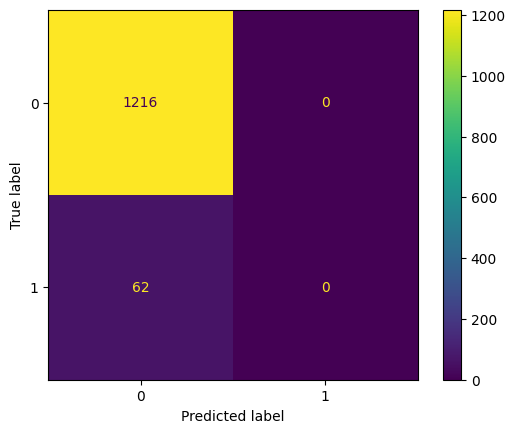

In [151]:
report_cm_threshold(model_3, X_test, y_test, threshold=0)

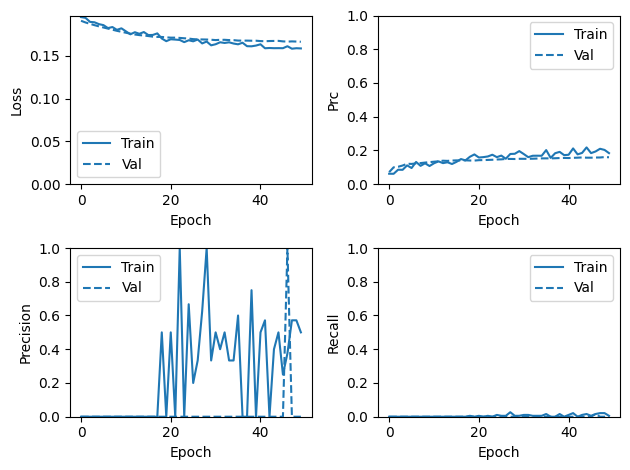

In [152]:
plot_metrics(history)

#### Class weights

In [154]:
total = df.shape[0]
total

5110

In [155]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 10.26


In [167]:
model_4 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[n_features]),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
])

 1/40 [..............................] - ETA: 0s - loss: 0.8153 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

C:\Users\User\AppData\Local\Temp\ipykernel_20504\3012804881.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1000us/step - loss: 0.8401 - accuracy: 0.3365 - precision: 0.0653 - recall: 0.9516 - auc: 0.7621 - prc: 0.1697         
Accuracy achieved:  [0.8401127457618713, 0.33646321296691895, 0.0652654841542244, 0.9516128897666931, 0.7621365785598755, 0.16970917582511902]


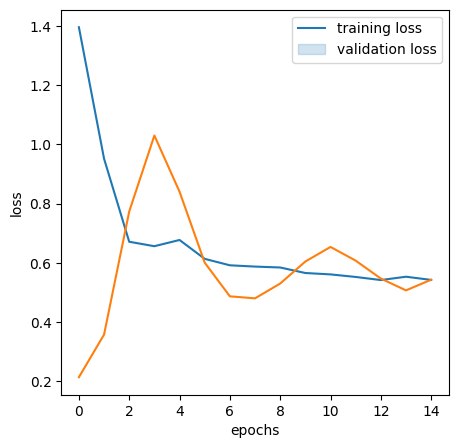

In [168]:
history, X_test, y_test, scaler_X, metrics = test_nn_model_classif(
              model_4, X, y,
              class_weight = class_weight,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = [
                  keras.metrics.BinaryAccuracy(name='accuracy'),
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc'), 
                  keras.metrics.AUC(name='prc', curve='PR') #precision-recall curve
              ],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=1024, epochs=50,
              early_stop=True,
              monitor = 'val_prc',
              monitor_mode = 'max',
              lr_schedule=True)

40/40 [==============================] - 0s 692us/step
predictions class count:
[[  0. 374.]
 [  1. 904.]]
model report:
              precision    recall  f1-score   support

           0       0.99      0.31      0.47      1216
           1       0.07      0.95      0.12        62

    accuracy                           0.34      1278
   macro avg       0.53      0.63      0.29      1278
weighted avg       0.95      0.34      0.45      1278

confusion matrix:


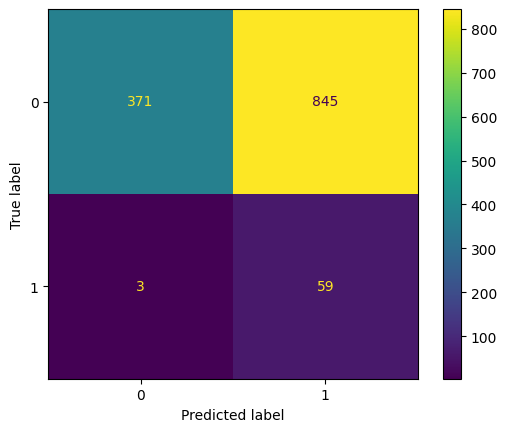

In [169]:
report_cm_threshold(model_4, X_test, y_test, threshold=0)

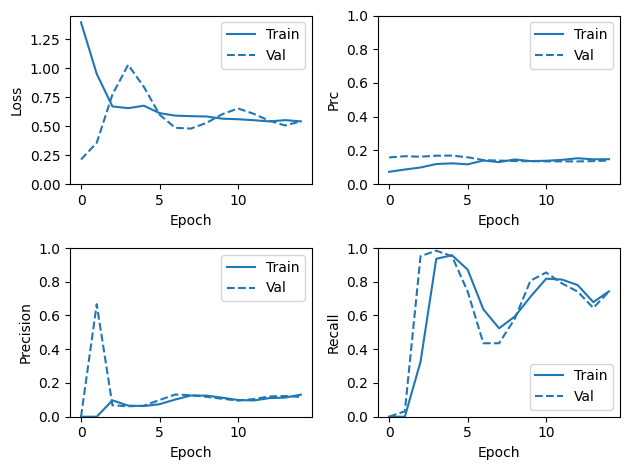

In [170]:
plot_metrics(history)

Interesting! it seems the model may have trained TOO well to clasify for class '1'. We could try adjusting for that with the classification threshold, this time, in a different direction than usual!

40/40 [==============================] - 0s 718us/step
predictions class count:
[[  0 665]
 [  1 613]]
model report:
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      1216
           1       0.08      0.82      0.15        62

    accuracy                           0.55      1278
   macro avg       0.53      0.68      0.42      1278
weighted avg       0.94      0.55      0.67      1278

confusion matrix:


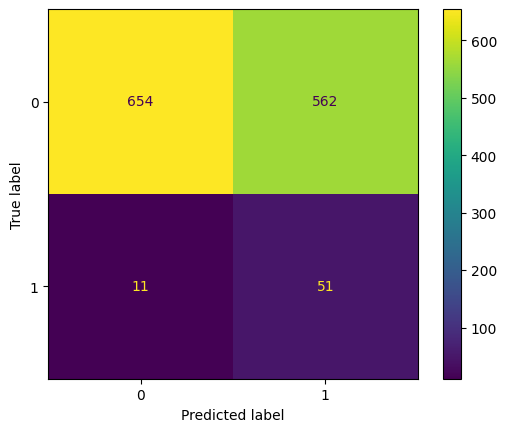

In [174]:
report_cm_threshold(model_4, X_test, y_test, threshold=0.6)

Idk, not that good

### Oversampling
Sometimes, we can try to mitigate the imbalance in the dataset, instead of in the model, by adding in random repeats of the minority class to the dataset - essentially fabricating reality, possibly worsening the generalization, although - if the model has more samples to learn proper representations of classes on - the benefit could be greater than the potential risk

### Feature selection
maybe the training is too muddied by too many variables, especially one-hot encoded ones, the learning curves seem "jumpy", switching between decisions, plus, there's clearly some overfitting going on, perhaps the model is focusing too much on combinations of features that don't help it discern the classess

Let's look at the features currently being used

In [180]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'smoking_status', 'Female', 'Male', 'Other',
       'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children',
       'Rural', 'Urban'],
      dtype='object')

Looking at the distributions between the cases with stroke or without stroke again:

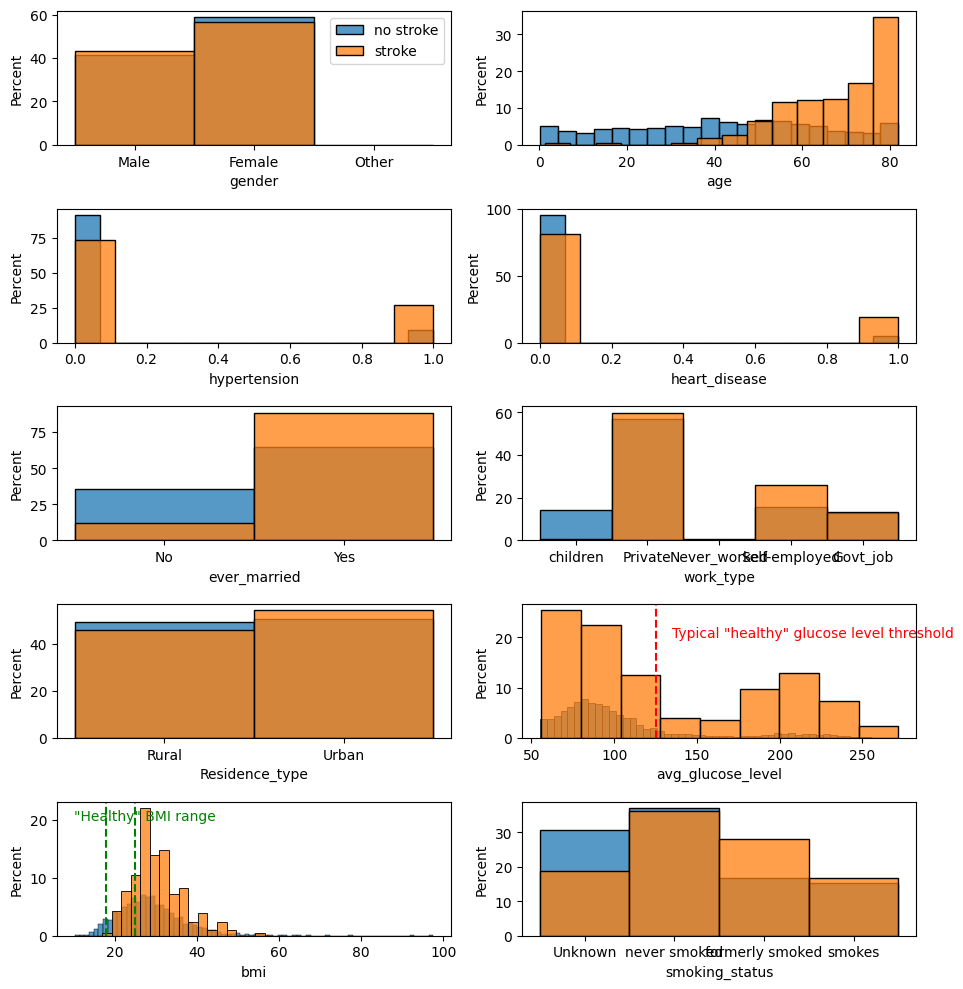

In [181]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
stroke_df = df[df['stroke'] == 1]
nostroke_df = df[df['stroke'] == 0]
cols_no_stroke = [col for col in cols if col != 'stroke']

ax = axes.ravel()

for i in range(10):
    # sns.histplot(data=df, x=cols_no_stroke[i], hue='stroke', stat='density', ax=ax[i])
    sns.histplot(data = nostroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])
    sns.histplot(data = stroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])

    # additional vertical lines
    dist_col = cols_no_stroke[i]
    if dist_col == 'bmi':
        ax[i].axvline(x=18, ymin=0, ymax=30, color="green", linestyle="dashed")
        ax[i].axvline(x=25, ymin=0, ymax=30, color="green", linestyle="dashed")
        ax[i].text(10, 20, '"Healthy" BMI range', color="green")
    if dist_col == "avg_glucose_level":
        ax[i].axvline(x=125, ymin=0, ymax=30, color="red", linestyle="dashed")
        ax[i].text(135, 20, 'Typical "healthy" glucose level threshold', color="red")
ax[0].legend(['no stroke', 'stroke'], loc='best')
fig.tight_layout()

Is is possible, that factors such as gender, residence type or work type don't contribute to the predictions at all - the distrubutions between the classes are too similar - let's start with dropping just them.

Theoretically, a neural network model should be doing such selection itself, by adjusting weights accordingly, reducing the weights of "useless" features to close to 0, or negative even, but why not help the model a little, if we have suspicions that such simple operations might prove beneficial

In [182]:
X = X.drop(['Female', 'Male', 'Other',
       'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children',
       'Rural', 'Urban'], axis=1)

In [186]:
n_features = X.shape[1]
n_features

7

In [187]:
model_4 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[n_features]),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
])

 1/40 [..............................] - ETA: 0s - loss: 0.4788 - accuracy: 0.8125 - precision: 0.1429 - recall: 1.0000 - auc: 0.8710 - prc: 0.1074

C:\Users\User\AppData\Local\Temp\ipykernel_20504\3012804881.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1ms/step - loss: 0.4979 - accuracy: 0.7441 - precision: 0.1485 - recall: 0.9032 - auc: 0.8799 - prc: 0.1961
Accuracy achieved:  [0.49794724583625793, 0.7441314458847046, 0.14854110777378082, 0.9032257795333862, 0.8798878192901611, 0.19612638652324677]


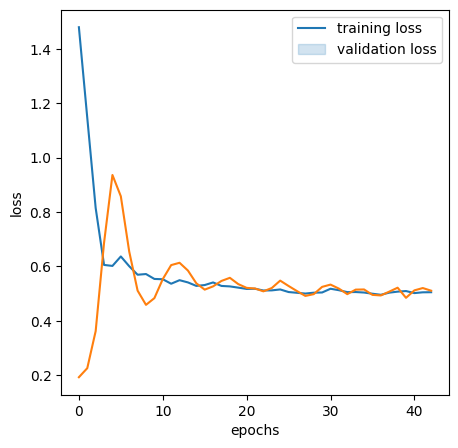

In [188]:
history, X_test, y_test, scaler_X, metrics = test_nn_model_classif(
              model_4, X, y,
              class_weight = class_weight,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = [
                  keras.metrics.BinaryAccuracy(name='accuracy'),
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc'), 
                  keras.metrics.AUC(name='prc', curve='PR') #precision-recall curve
              ],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=1024, epochs=50,
              early_stop=True,
              monitor = 'val_prc',
              monitor_mode = 'max',
              lr_schedule=True)

40/40 [==============================] - 0s 693us/step
predictions class count:
[[  0. 901.]
 [  1. 377.]]
model report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1216
           1       0.15      0.90      0.26        62

    accuracy                           0.74      1278
   macro avg       0.57      0.82      0.55      1278
weighted avg       0.95      0.74      0.82      1278

confusion matrix:


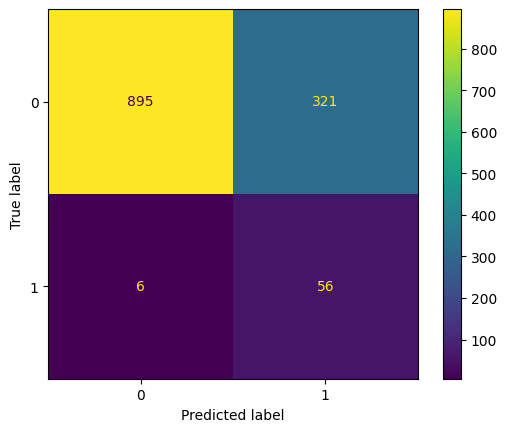

In [189]:
report_cm_threshold(model_4, X_test, y_test, threshold=0)

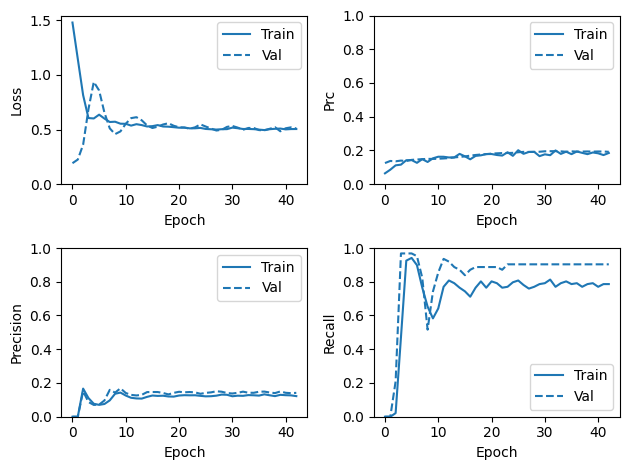

In [190]:
plot_metrics(history)

### Wow, our best model yet! And without threshold tuning

### Feature engineering

## TODO:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
* oversampling
* feature engineering - bmi categories instead of value
* dropping some columns - clearly there is some overfitting going on
* maybe the training is too muddied by too many variables, especially one-hot encoded ones, the learning curves seem "jumpy", switching between decisions

In [178]:
# pos_index = df[df['stroke'] == 1].index
# pos_index

In [177]:
# pos_X = df[df['stroke']]

In [122]:
# metrics

In [111]:
history

In [121]:
# metrics = [
#   keras.metrics.BinaryAccuracy(name='accuracy'),
#   keras.metrics.Precision(name='precision'),
#   keras.metrics.Recall(name='recall'),
#   keras.metrics.AUC(name='auc'), 
#   keras.metrics.AUC(name='prc', curve='PR') #precision-recall curve
# ]

In [120]:
# for m in metrics:
    # print(m.name)